<a href="https://colab.research.google.com/github/Summit2/ML_education/blob/main/%5Bhomework%5Ddense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

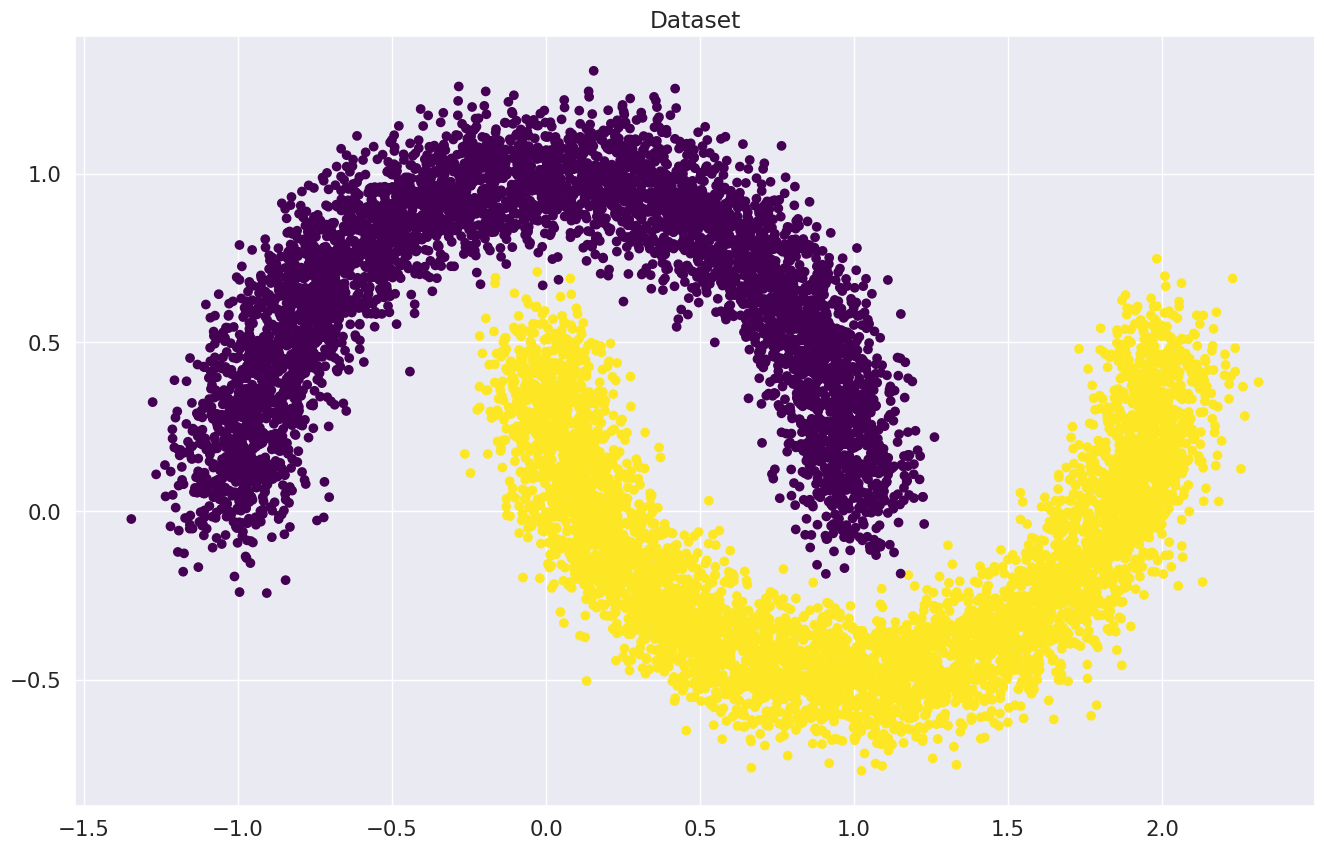

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t =  torch.tensor(X_train,dtype=torch.float32)
y_train_t =   torch.tensor(y_train,dtype=torch.float32)
X_val_t =  torch.tensor(X_val,dtype=torch.float32)
y_val_t = torch.tensor(y_val,dtype=torch.float32)


Создаем `Dataset` и `DataLoader`.

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, drop_last = True) #дропнул последний батч, потому что он получался большего размера, чем 128
val_dataloader = DataLoader(val_dataset, batch_size=128, drop_last = True)

In [8]:
y_train_t.size()

torch.Size([7500])

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features)) #Число фичей на входе и ответов на выходе
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x@self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [10]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [11]:
# всего 3 обучаемых параметра - 2 в weights и 1 в bias

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ: **

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch.reshape(128,1)) # YOUR CODE. Compute loss #дропнул последний батч, потому что он получался большего размера, чем 128
        # print(outp.size())
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  F.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\Последняя итерация : {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5078125
Iteration: 100
Batch accuracy: 0.75
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.8515625
Iteration: 400
Batch accuracy: 0.8671875
Iteration: 500
Batch accuracy: 0.78125
Iteration: 600
Batch accuracy: 0.875
Iteration: 700
Batch accuracy: 0.8671875
\Последняя итерация : 747.Convergence. Stopping iterations.


In [13]:
#всего 917 итераций

In [14]:
linear_regression.weights

Parameter containing:
tensor([[ 1.3031],
        [-2.6682]], requires_grad=True)

### Визуализируем результаты

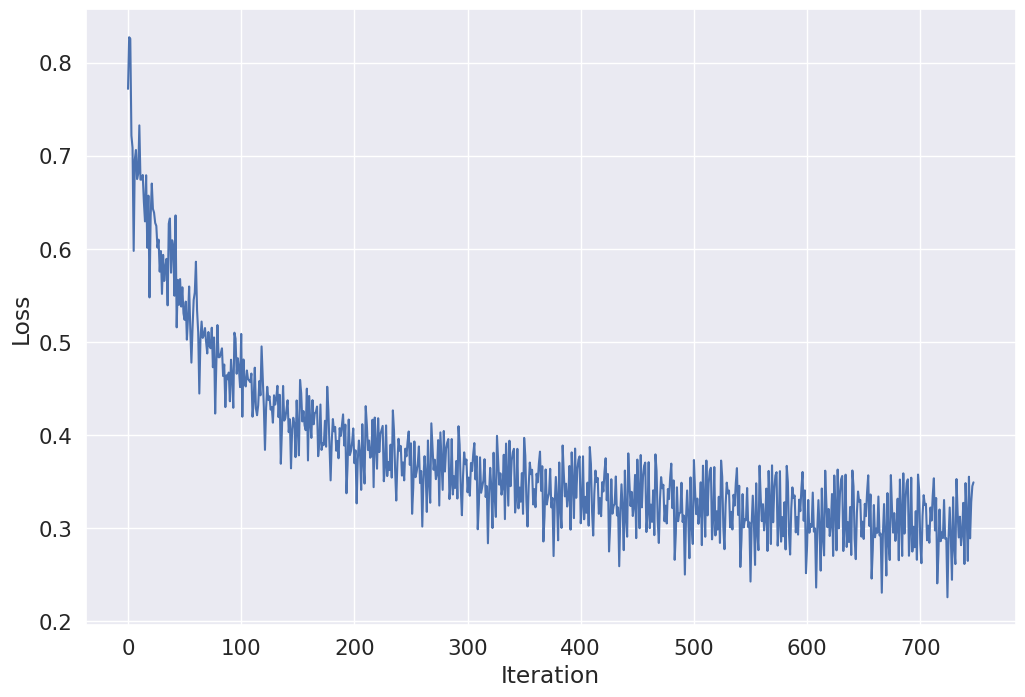

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

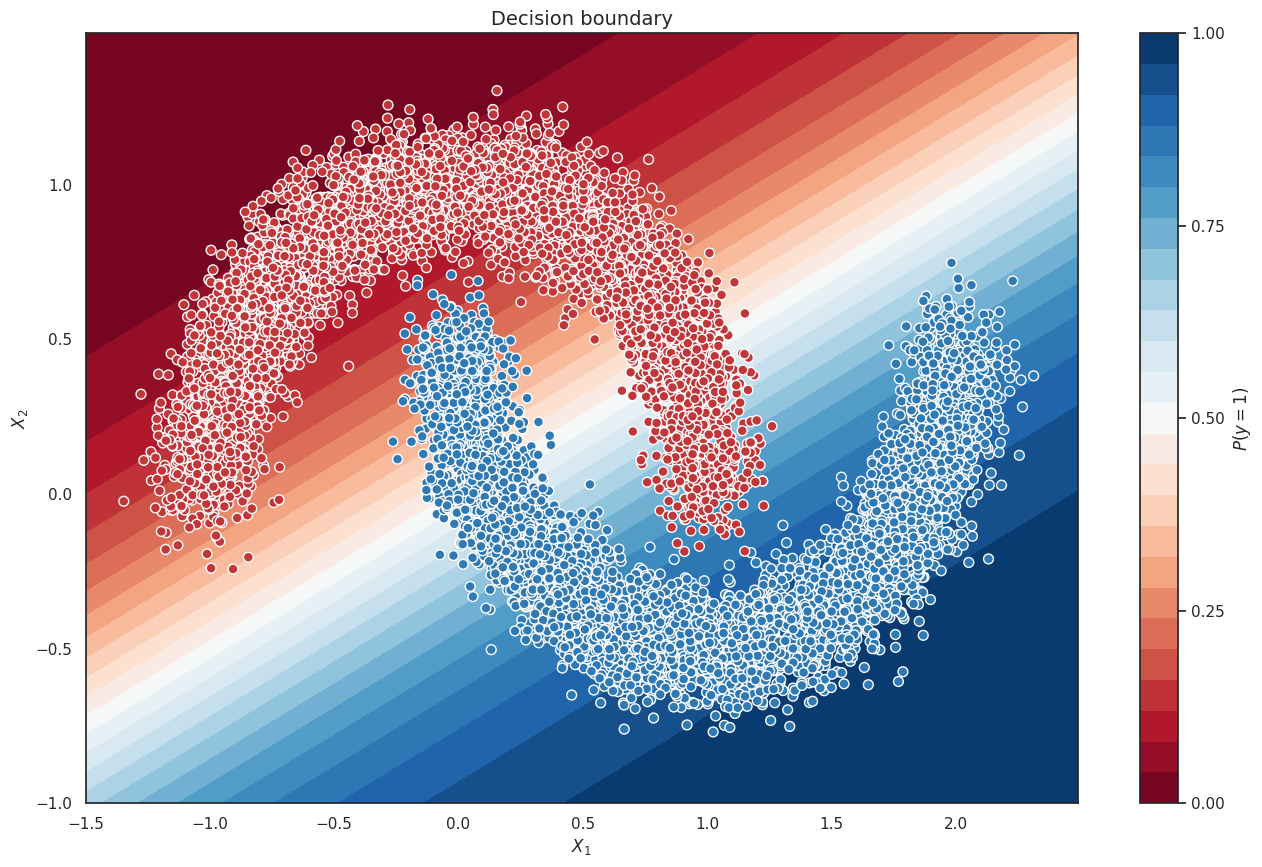

In [16]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [17]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # <YOUR CODE>
        preds =F.sigmoid( model.forward(x_batch))#YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [18]:
from sklearn.metrics import accuracy_score
y_predicted =np.where( predict(val_dataloader, linear_regression) >0.5,1,0)
# print(y_predicted)
# print(y_val)
accuracy_score(y_val[:2432],y_predicted) #валидационную выборку из-за этого срезал чутка

# YOUR CODE. Compute total accuracy

0.8614309210526315

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [19]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=100)# YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size =100)# YOUR CODE GOES HERE



100%|██████████| 9912422/9912422 [00:00<00:00, 92013622.53it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 14291610.88it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44152912.16it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23665253.13it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [20]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
activation = nn.ELU()



In [23]:

#немного поменял исходный файл, чтобы в модель можно было засовывать разные функции активации


def nn_model(activation_func):
  '''
  возращает модель НС с входным значением - функцией активации
  '''
  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28,128), #размер вектора входного слоя не очень понятен
      nn.Linear(128,128),
      activation,
      nn.Linear(128,10)


  )
  return model

In [24]:
model = nn_model(activation).to(device)


In [25]:
criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [26]:
def training_cycle(loaders, model, criterion, optimizer):
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if k == "train":
                    model.train()

                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()

                    with torch.no_grad():
                      outp = model(x_batch) # здесь мы делаем предсказания по батчам уже для валидационной выборки
                # print('outp',outp)
                preds = outp.argmax(-1)  # эта функция выдает нам индексы элементов с наибольшим значением ( в данном случае вероятностью) а для нас это значит номер класса, к которому принадлежит объект
                # print('preds',preds)
                preds_np = preds.cpu().detach().numpy()
                # print(preds_np)
                y_batch_np = y_batch.cpu().detach().numpy()
                # print(y_batch_np)
                correct = (preds_np == y_batch_np ).sum()
                # print(correct)
                all = preds.shape[0]
                # print(all)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [27]:
accuracy_with_ELU = training_cycle(loaders, model, criterion, optimizer)


Epoch: 1
Loader: train. Accuracy: 0.8815666666666667
Loader: valid. Accuracy: 0.9065
Epoch: 2
Loader: train. Accuracy: 0.9396333333333333
Loader: valid. Accuracy: 0.9381
Epoch: 3
Loader: train. Accuracy: 0.9564833333333334
Loader: valid. Accuracy: 0.9534
Epoch: 4
Loader: train. Accuracy: 0.96425
Loader: valid. Accuracy: 0.9626
Epoch: 5
Loader: train. Accuracy: 0.9689
Loader: valid. Accuracy: 0.9659
Epoch: 6
Loader: train. Accuracy: 0.9724333333333334
Loader: valid. Accuracy: 0.9671
Epoch: 7
Loader: train. Accuracy: 0.9741166666666666
Loader: valid. Accuracy: 0.9667
Epoch: 8
Loader: train. Accuracy: 0.9760666666666666
Loader: valid. Accuracy: 0.9668
Epoch: 9
Loader: train. Accuracy: 0.9792166666666666
Loader: valid. Accuracy: 0.9676
Epoch: 10
Loader: train. Accuracy: 0.9801166666666666
Loader: valid. Accuracy: 0.9698


In [28]:
!nvidia-smi

Wed Nov  1 21:13:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |    857MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
elu_accuracy = accuracy_with_ELU['valid']

In [30]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
# activation_functions = [nn.ELU(),nn.ReLU(), nn.LeakyReLU()]


def test_activation_function(activation):
  '''
  функция для тестирования разных ф.активации НС
  На вход подается функция активации
  Остальные параметры - датасет, лосс, тип градиентного спуска - неизменны

  Функция возвращает список значений accuracy для заданной ф.активации по всем эпохам
  '''
  model = nn_model(activation).to(device)
  loaders = {"train": train_dataloader, "valid": valid_dataloader}
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())


  accuracy = training_cycle(loaders,model,criterion,optimizer)
  return accuracy

In [31]:
#не хочу подавать на вход список функций, так в одной ячейке все будет считаться. если что-то будет неверно, придется каждый раз пересчитывать всё

In [32]:

relu_accuracy = test_activation_function(nn.ReLU())


Epoch: 1
Loader: train. Accuracy: 0.8813833333333333
Loader: valid. Accuracy: 0.9223
Epoch: 2
Loader: train. Accuracy: 0.9406333333333333
Loader: valid. Accuracy: 0.9456
Epoch: 3
Loader: train. Accuracy: 0.9564
Loader: valid. Accuracy: 0.9562
Epoch: 4
Loader: train. Accuracy: 0.9646333333333333
Loader: valid. Accuracy: 0.9629
Epoch: 5
Loader: train. Accuracy: 0.9692166666666666
Loader: valid. Accuracy: 0.9639
Epoch: 6
Loader: train. Accuracy: 0.9726333333333333
Loader: valid. Accuracy: 0.9674
Epoch: 7
Loader: train. Accuracy: 0.9755
Loader: valid. Accuracy: 0.9671
Epoch: 8
Loader: train. Accuracy: 0.97715
Loader: valid. Accuracy: 0.9667
Epoch: 9
Loader: train. Accuracy: 0.9774166666666667
Loader: valid. Accuracy: 0.9718
Epoch: 10
Loader: train. Accuracy: 0.97955
Loader: valid. Accuracy: 0.9751


In [33]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

Epoch: 1
Loader: train. Accuracy: 0.88295
Loader: valid. Accuracy: 0.9167
Epoch: 2
Loader: train. Accuracy: 0.9407166666666666
Loader: valid. Accuracy: 0.9418
Epoch: 3
Loader: train. Accuracy: 0.9563333333333334
Loader: valid. Accuracy: 0.9571
Epoch: 4
Loader: train. Accuracy: 0.9645666666666667
Loader: valid. Accuracy: 0.9622
Epoch: 5
Loader: train. Accuracy: 0.9705666666666667
Loader: valid. Accuracy: 0.965
Epoch: 6
Loader: train. Accuracy: 0.9743833333333334
Loader: valid. Accuracy: 0.9657
Epoch: 7
Loader: train. Accuracy: 0.9755
Loader: valid. Accuracy: 0.96
Epoch: 8
Loader: train. Accuracy: 0.97805
Loader: valid. Accuracy: 0.9668
Epoch: 9
Loader: train. Accuracy: 0.9778666666666667
Loader: valid. Accuracy: 0.97
Epoch: 10
Loader: train. Accuracy: 0.9796
Loader: valid. Accuracy: 0.9711


In [39]:
plain_accuracy = test_activation_function(Identical)['valid']

Epoch: 1
Loader: train. Accuracy: 0.8837333333333334
Loader: valid. Accuracy: 0.9101
Epoch: 2
Loader: train. Accuracy: 0.93885
Loader: valid. Accuracy: 0.9468
Epoch: 3
Loader: train. Accuracy: 0.95545
Loader: valid. Accuracy: 0.96
Epoch: 4
Loader: train. Accuracy: 0.96465
Loader: valid. Accuracy: 0.9654
Epoch: 5
Loader: train. Accuracy: 0.97035
Loader: valid. Accuracy: 0.9676
Epoch: 6
Loader: train. Accuracy: 0.9736833333333333
Loader: valid. Accuracy: 0.9642
Epoch: 7
Loader: train. Accuracy: 0.9757166666666667
Loader: valid. Accuracy: 0.9682
Epoch: 8
Loader: train. Accuracy: 0.97755
Loader: valid. Accuracy: 0.9688
Epoch: 9
Loader: train. Accuracy: 0.9785833333333334
Loader: valid. Accuracy: 0.9684
Epoch: 10
Loader: train. Accuracy: 0.9794
Loader: valid. Accuracy: 0.9684


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

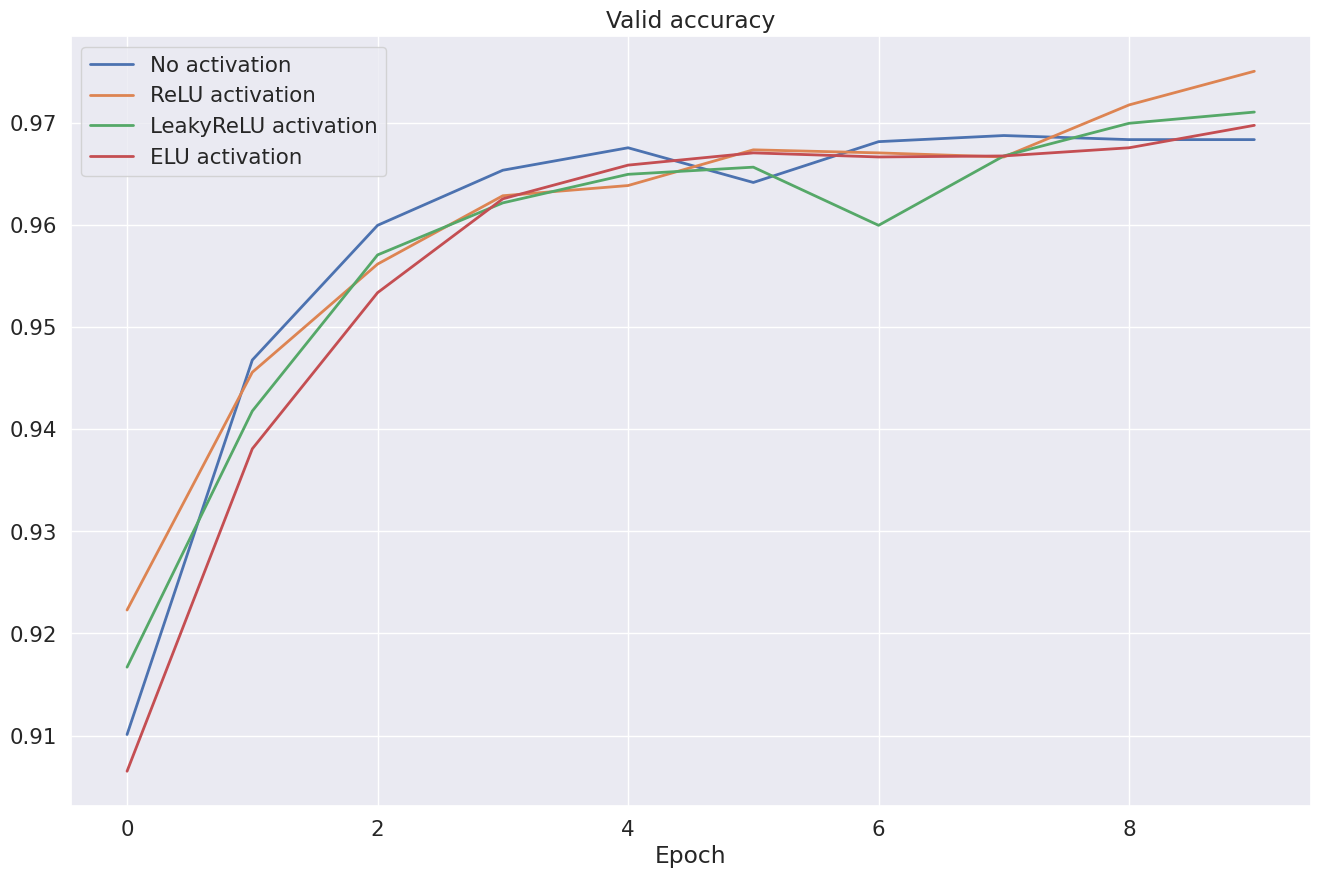

In [48]:
max_epochs = 10
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(10), plain_accuracy['valid'], label="No activation", linewidth=2)

plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

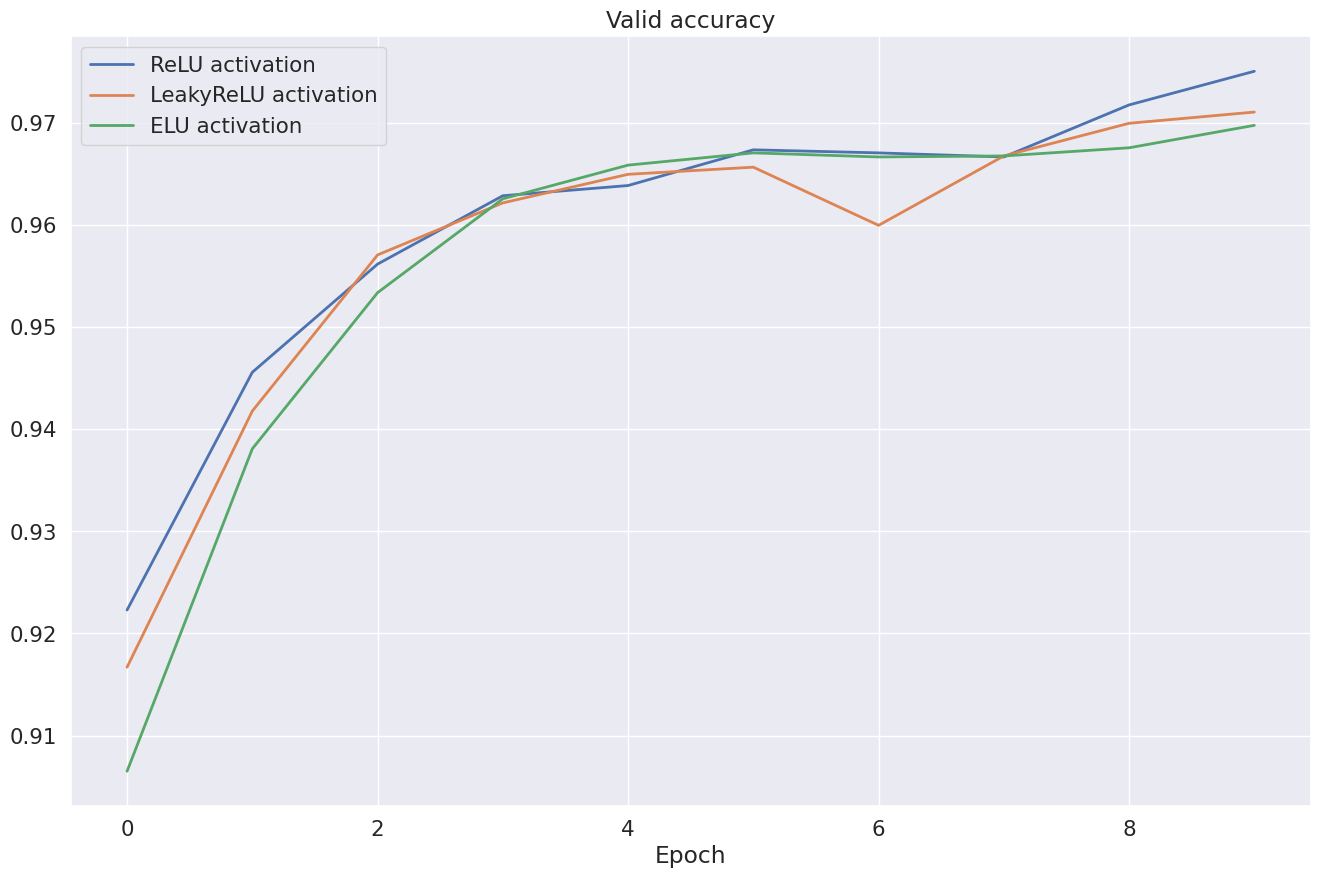

In [49]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: видно на графике. не пишу в ответ точную функцию, так как из-за рандома выигрывают разные функции активации**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [50]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-01 21:31:08--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   119KB/s    in 0.4s    

2023-11-01 21:31:09 (119 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



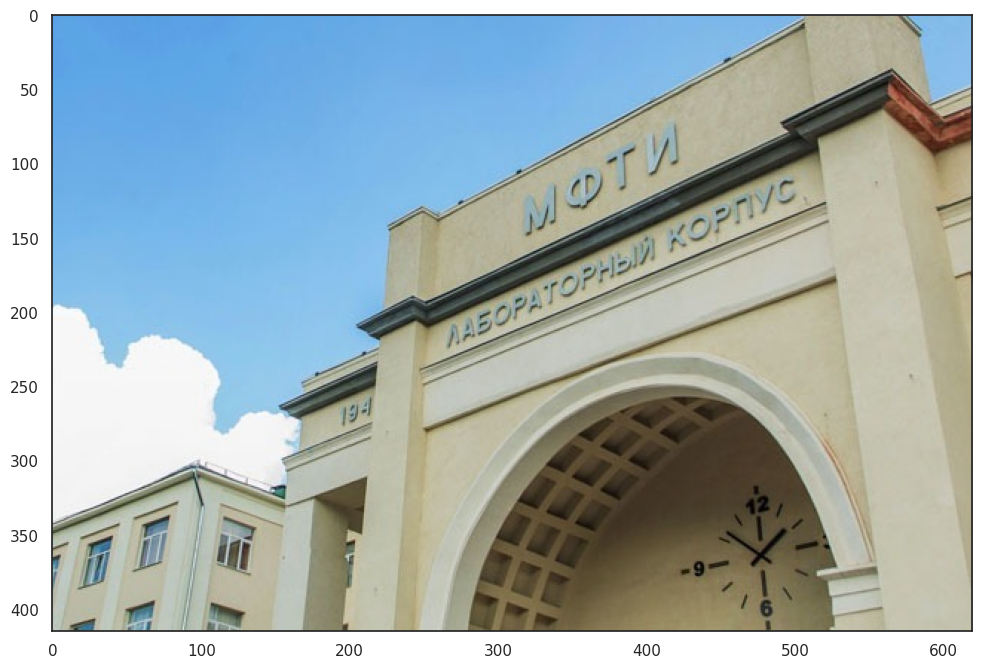

In [51]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [52]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

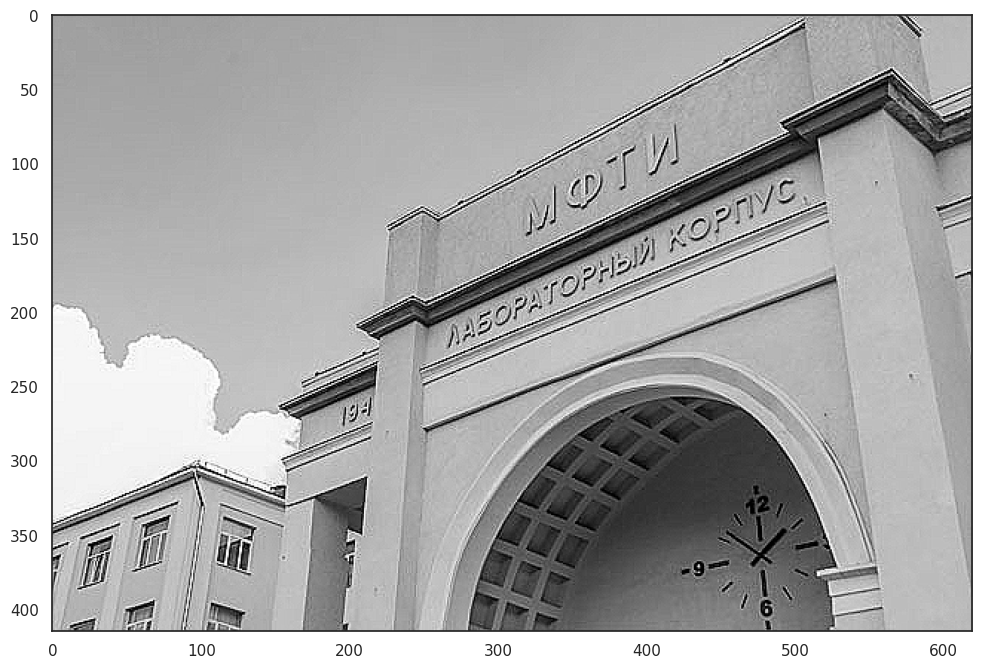

In [53]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** A - 3
Б - 5
В - 4
Г - 6
Д - 2
Е - 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [59]:
torch.cuda.empty_cache()

In [57]:
!nvidia-smi

Wed Nov  1 21:31:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |    857MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [58]:


train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size =128 )# , pin_memory = True)


In [60]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 =  nn.Conv2d(6,16,3)
        self.pool2 = nn.MaxPool2d(2)
        #nn.flatten()
        self.fc1 = nn.Linear(400,120) #!!!
        #nn.ReLU()
        self.fc2 = nn.Linear(120,84) #YOUR CODE
        #nn.ReLU()
        self.fc3 = nn.Linear(84,10)#YOUR CODE

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [61]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [62]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [63]:
!nvidia-smi

Wed Nov  1 21:32:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |    857MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [64]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch =  x_batch.to(device), y_batch.to(device)
            if k == "train":
                model.train()

                optimizer.zero_grad()
                # print(x_batch.size())
                outp = model(x_batch)
                # print(outp)
                # print(y_batch,y_batch.size())
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()

                with torch.no_grad():
                  outp = model(x_batch) # здесь мы делаем предсказания по батчам уже для валидационной выборки
            # print('outp',outp)
            preds = outp.argmax(-1)  # эта функция выдает нам индексы элементов с наибольшим значением ( в данном случае вероятностью) а для нас это значит номер класса, к которому принадлежит объект
            # print('preds',preds)
            preds_np = preds.cpu().detach().numpy()
            # print(preds_np)
            y_batch_np = y_batch.cpu().detach().numpy()
            # print(y_batch_np)
            correct = (preds_np == y_batch_np ).sum()
            # print(correct)
            all = preds.shape[0]
            # print(all)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)




Epoch: 1
Loader: train. Accuracy: 0.90485
Loader: valid. Accuracy: 0.9672
Epoch: 2
Loader: train. Accuracy: 0.9694833333333334
Loader: valid. Accuracy: 0.9738
Epoch: 3
Loader: train. Accuracy: 0.9762166666666666
Loader: valid. Accuracy: 0.9773
Epoch: 4
Loader: train. Accuracy: 0.9797833333333333
Loader: valid. Accuracy: 0.978
Epoch: 5
Loader: train. Accuracy: 0.9819833333333333
Loader: valid. Accuracy: 0.9778
Epoch: 6
Loader: train. Accuracy: 0.9836166666666667
Loader: valid. Accuracy: 0.9781
Epoch: 7
Loader: train. Accuracy: 0.9846
Loader: valid. Accuracy: 0.9782
Epoch: 8
Loader: train. Accuracy: 0.9855166666666667
Loader: valid. Accuracy: 0.9789
Epoch: 9
Loader: train. Accuracy: 0.9862833333333333
Loader: valid. Accuracy: 0.9787
Epoch: 10
Loader: train. Accuracy: 0.98685
Loader: valid. Accuracy: 0.9778


In [65]:
!nvidia-smi

Wed Nov  1 21:34:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    26W /  70W |   1163MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [66]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

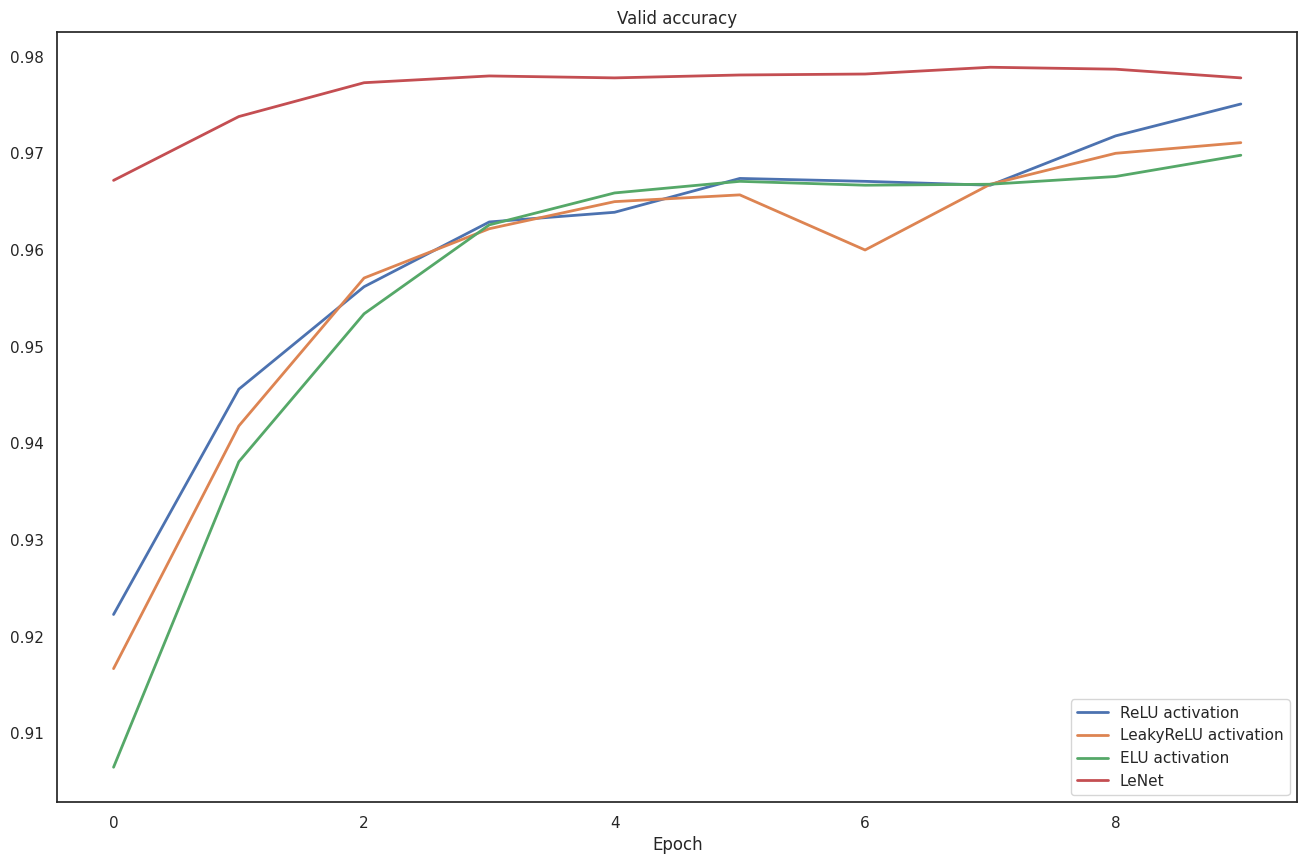

In [67]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [69]:

print('lenet_accuracy: ', round(lenet_accuracy[-1],2))

lenet_accuracy:  0.98
